In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re

In [2]:
plt.rcParams['font.size'] = 40
plt.rcParams['figure.figsize'] = (40,30)

In [3]:
# source: https://www.kaggle.com/rtatman/chocolate-bar-ratings
df = pd.read_csv('flavors_of_cacao.csv')

In [4]:
# cleaning column names
col_names = []
for i in df.columns.tolist():
    col_names.append(i.replace('\n', '_').replace(' ', '_').lower())
col_names[0], col_names[1] = 'company', 'specific_bean_origin'
df.columns = col_names
df

,company,specific_bean_origin,ref,review_date,cocoa_percent,company_location,rating,bean_type,broad_bean_origin
0,A. Morin,Agua Grande,1876,2016,63%,France,3.75,,Sao Tome
1,A. Morin,Kpime,1676,2015,70%,France,2.75,,Togo
2,A. Morin,Atsane,1676,2015,70%,France,3.00,,Togo
3,A. Morin,Akata,1680,2015,70%,France,3.50,,Togo
4,A. Morin,Quilla,1704,2015,70%,France,3.50,,Peru
...,...,...,...,...,...,...,...,...,...
1790,Zotter,Peru,647,2011,70%,Austria,3.75,,Peru
1791,Zotter,Congo,749,2011,65%,Austria,3.00,Forastero,Congo
1792,Zotter,Kerala State,749,2011,65%,Austria,3.50,Forastero,India
1793,Zotter,Kerala State,781,2011,62%,Austria,3.25,,India


In [5]:
# check duplicates 
df[df.duplicated()]

,company,specific_bean_origin,ref,review_date,cocoa_percent,company_location,rating,bean_type,broad_bean_origin


In [6]:
# check missing data, but our eyeballs tell us that there are many missing values in Bean Type
df.isna().sum()

company                 0
specific_bean_origin    0
ref                     0
review_date             0
cocoa_percent           0
company_location        0
rating                  0
bean_type               1
broad_bean_origin       1
dtype: int64

In [7]:
# to find out what happen, Bean Type records include '\xa0'
df.iloc[0,-2]

'\xa0'

In [8]:
def helper(x):
    if u'\xa0' == x:
        return np.nan
    else:
        return x

In [9]:
a = df.iloc[0,-2]
for i in df.columns:
    if df[i].dtype == 'O':
        if df[i].str.contains(a).any():
            df[i] = df[i].apply(lambda x: helper(x))

In [ ]:
# around 50% of Bean Type are empty 
(df.isna().sum() / df.shape[0] * 100).plot(kind='bar')
plt.title('Missing Values Percentage')
plt.xticks(rotation=-90)

In [18]:
# dropping bean_type columns as too many missing data and ref column 
df.drop(columns=['bean_type', 'ref'], inplace=True)

# drop missing values
df.dropna(subset=['broad_bean_origin'], inplace=True)

# transform cocoa_percent
df['cocoa_percent'] = df['cocoa_percent'].apply(lambda x: float(x.replace('%', '')))

# What’s the relationship between cocoa solids percentage and rating?

The higher content of cocoa may not mean a better rating, I believe it is more about trend of people preference. 
By 2008, companies were producing chocolate with more cocoa, but the average rating was greatly decreased. 
Then, the cocoa percentage dropped in 2009 and the rating raise. 

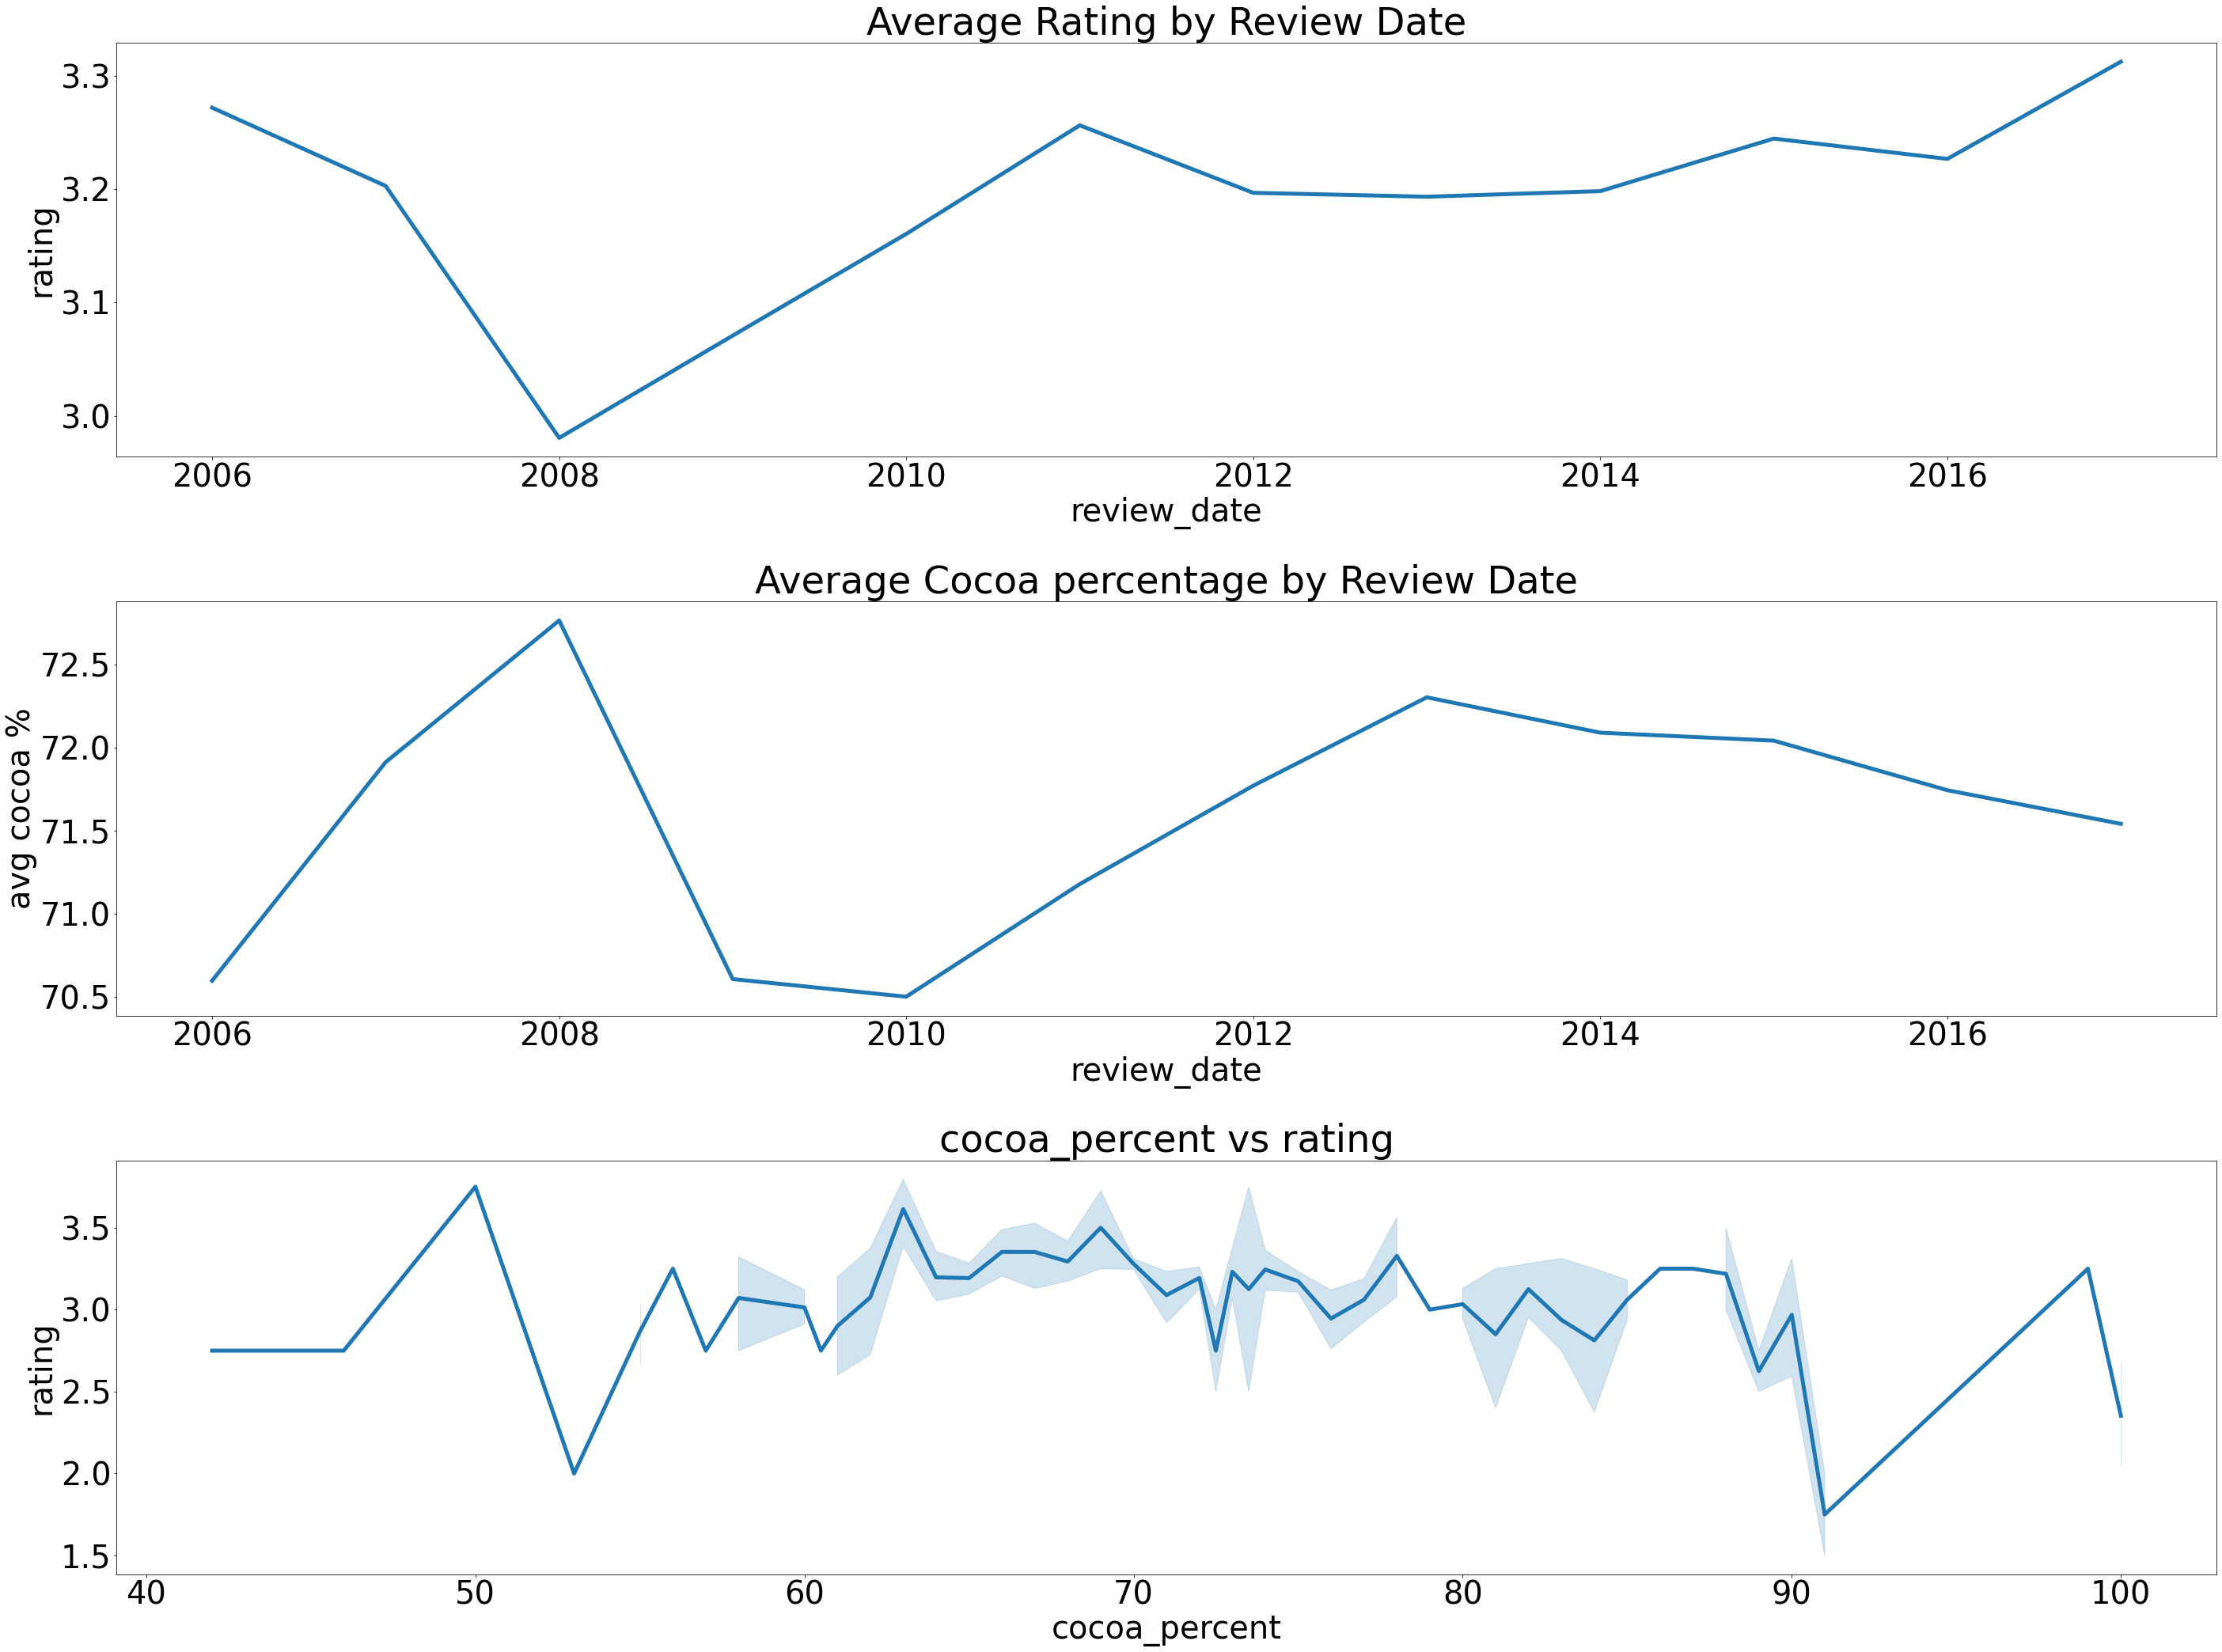

In [78]:
# People don't seem to enjoy chocolate in 2008 
plt.subplot(311)
sns.lineplot(data=df, x='review_date', y='rating', ci=None, lw=5)
plt.title('Average Rating by Review Date')

# There is a drop between 2008 and 2009
plt.subplot(312)
sns.lineplot(data=df, x='review_date', y='cocoa_percent', ci=None, lw=5)
plt.title('Average Cocoa percentage by Review Date')
plt.ylabel('avg cocoa %')

# more cocoa != higher rating
plt.subplot(313)
sns.lineplot(data=df, x='cocoa_percent', y='rating', lw=5)
plt.title('cocoa_percent vs rating')

plt.tight_layout()

## Where are the best cocoa beans grown?

The 5 bean origins that are rated mostly in this dataset are: Venezuela, Ecuador, Peru, Madagascar and Dominican Republic.
Cocoa from Dominican Republic did not score a impressive score before 2016 but greatly impress people and rise up to the top in 2017.

In [406]:
def plot_trend(feature, n=5):
    plt.subplot(211)
    temp_df = df[feature].value_counts().nlargest(n).reset_index()
    top_ls = temp_df['index'].tolist()
    sns.barplot(data=temp_df, x='index', y=feature)
    plt.title(f'{n} Mostly Rated {feature}')
    plt.xlabel(feature)
    plt.ylabel('count')

    plt.subplot(212)
    temp_df = df[df[feature].isin(top_ls)].groupby(['review_date',  feature]).aggregate({'rating':'mean'}).reset_index()
    sns.lineplot(data=temp_df, x='review_date', y='rating', hue=feature, lw=5)
    plt.title(f'Ratings per year for {n} Mostly Rated {feature}')
    plt.legend(top_ls, loc='upper left')

    plt.tight_layout()
    plt.show()

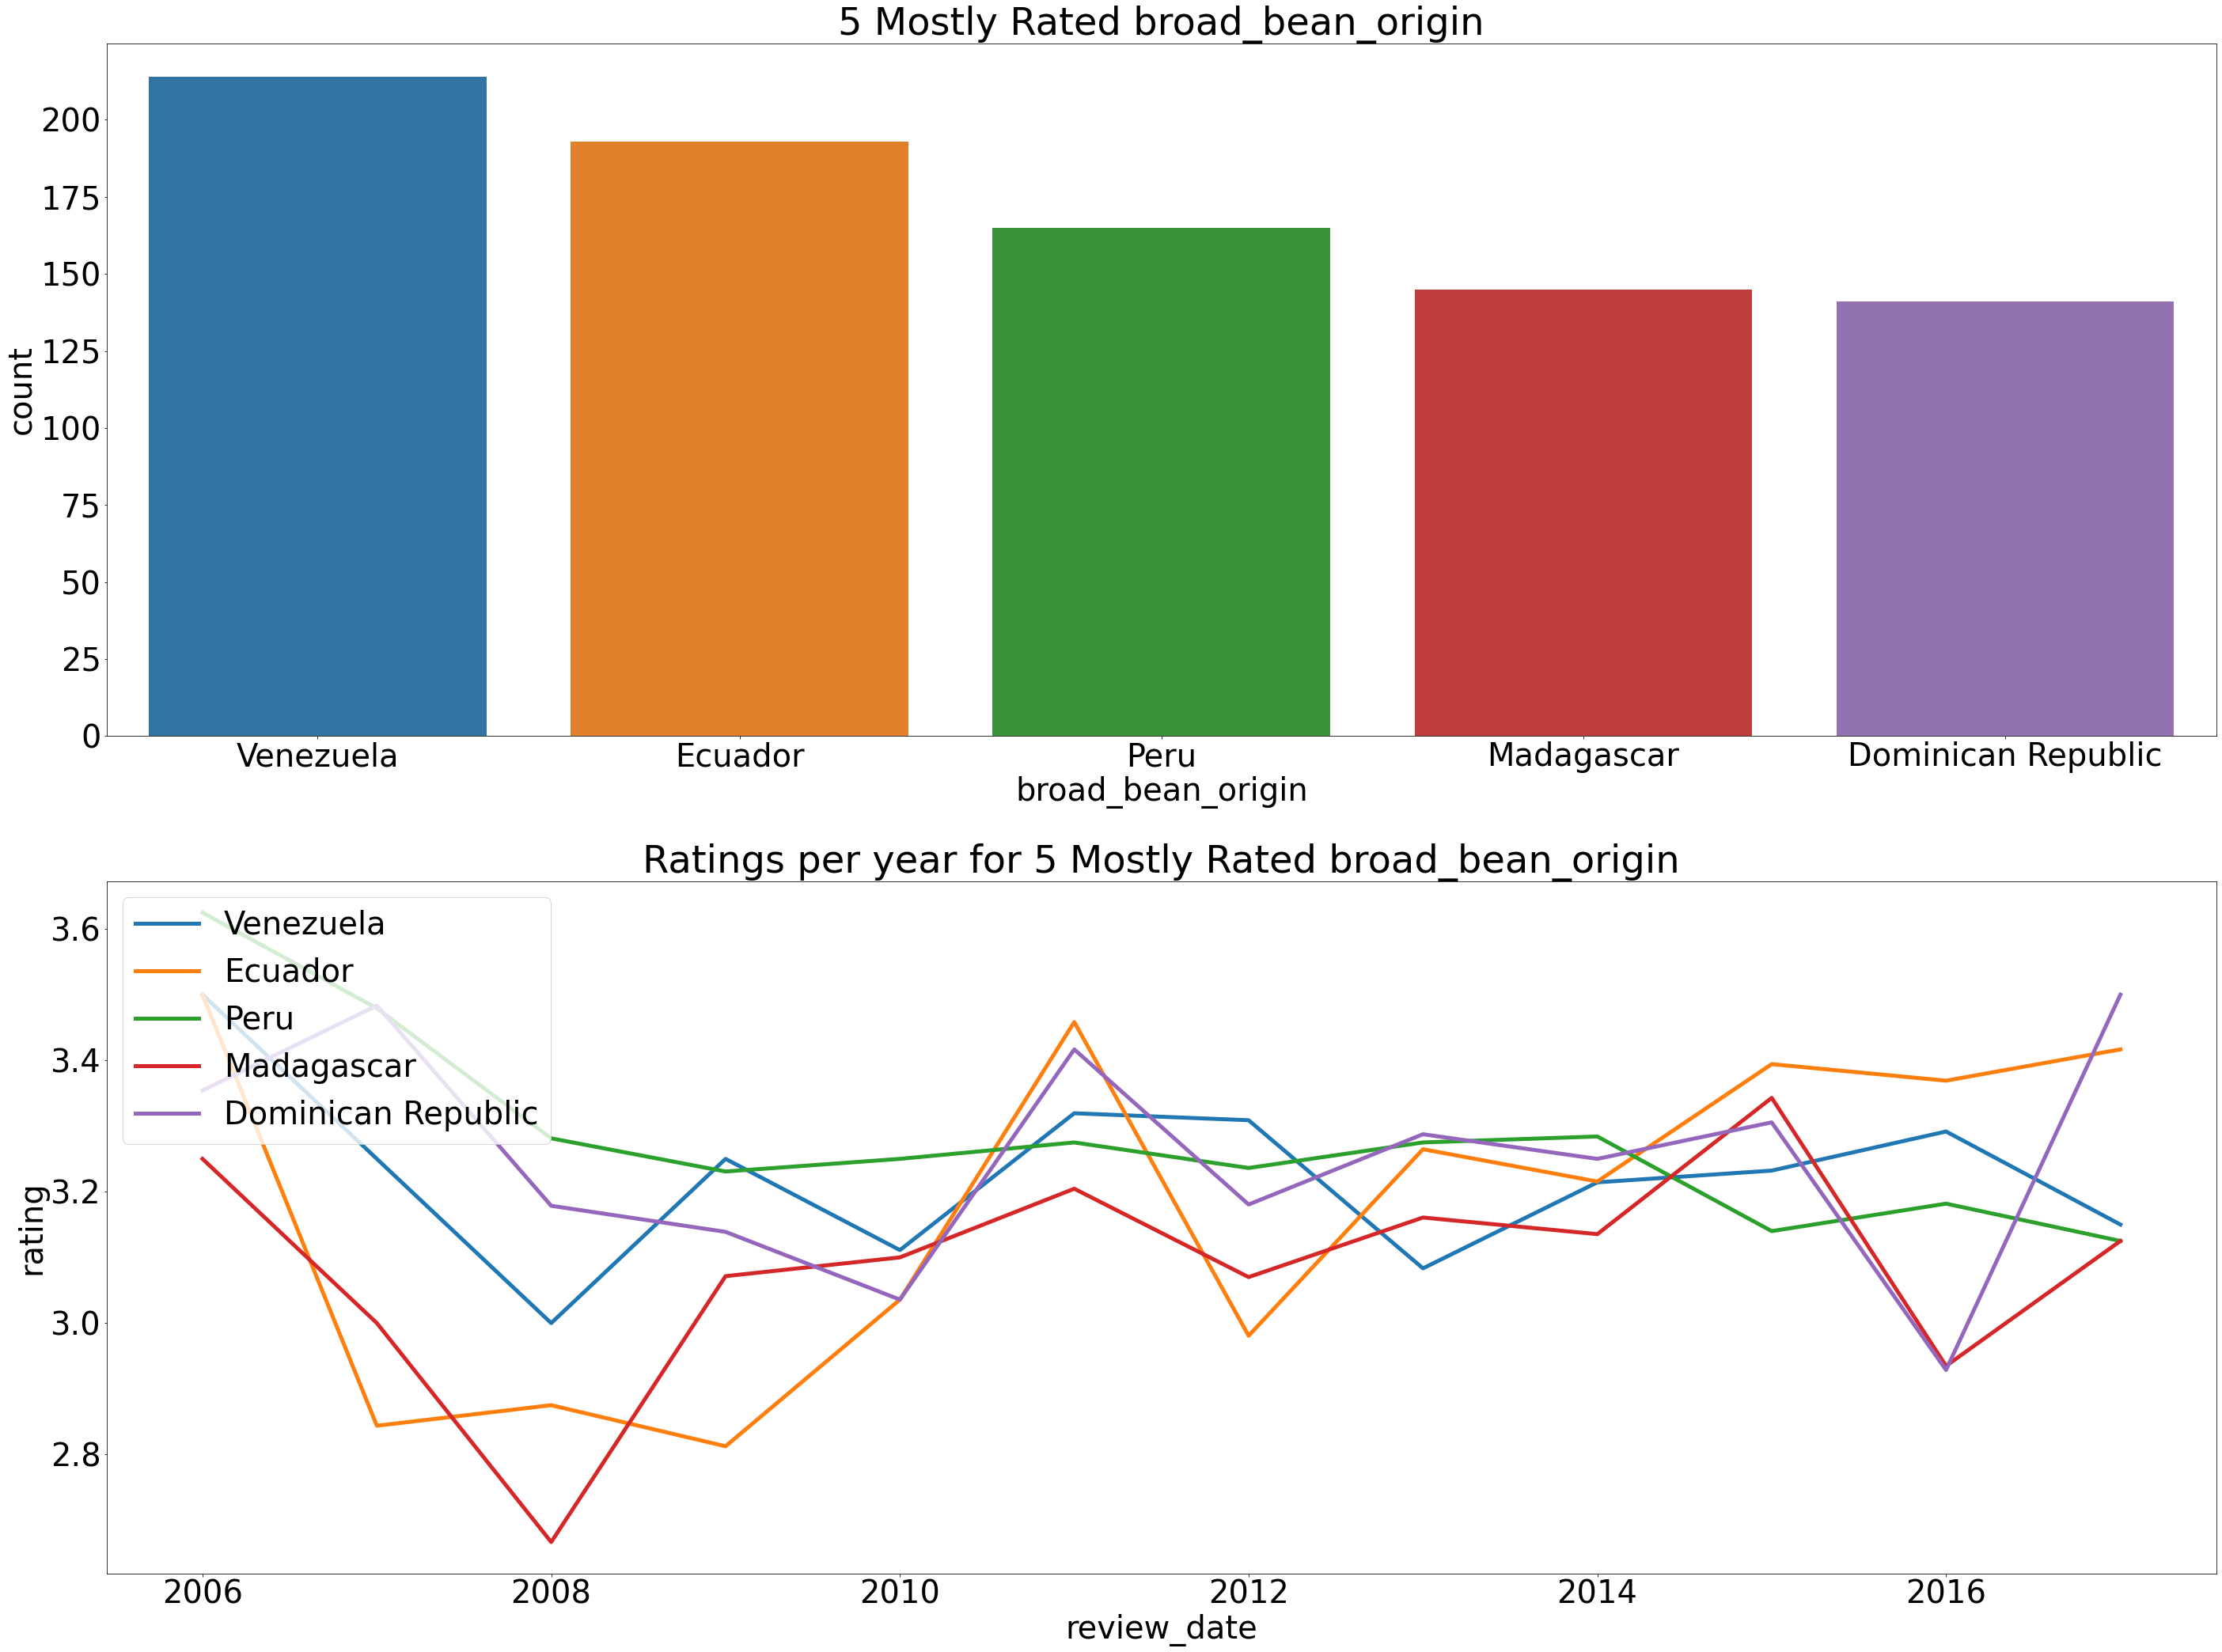

In [408]:
plot_trend('broad_bean_origin')

# Which countries produce the highest-rated bars?
Around 100 Canadian Chocolate makers are rated in this dataset, they scored the best rate in 2016.
More than 700 companies from USA are getting rated in this dataset. Quality-wise, USA chocolate makers are doing well, they are always gettng above 3.  

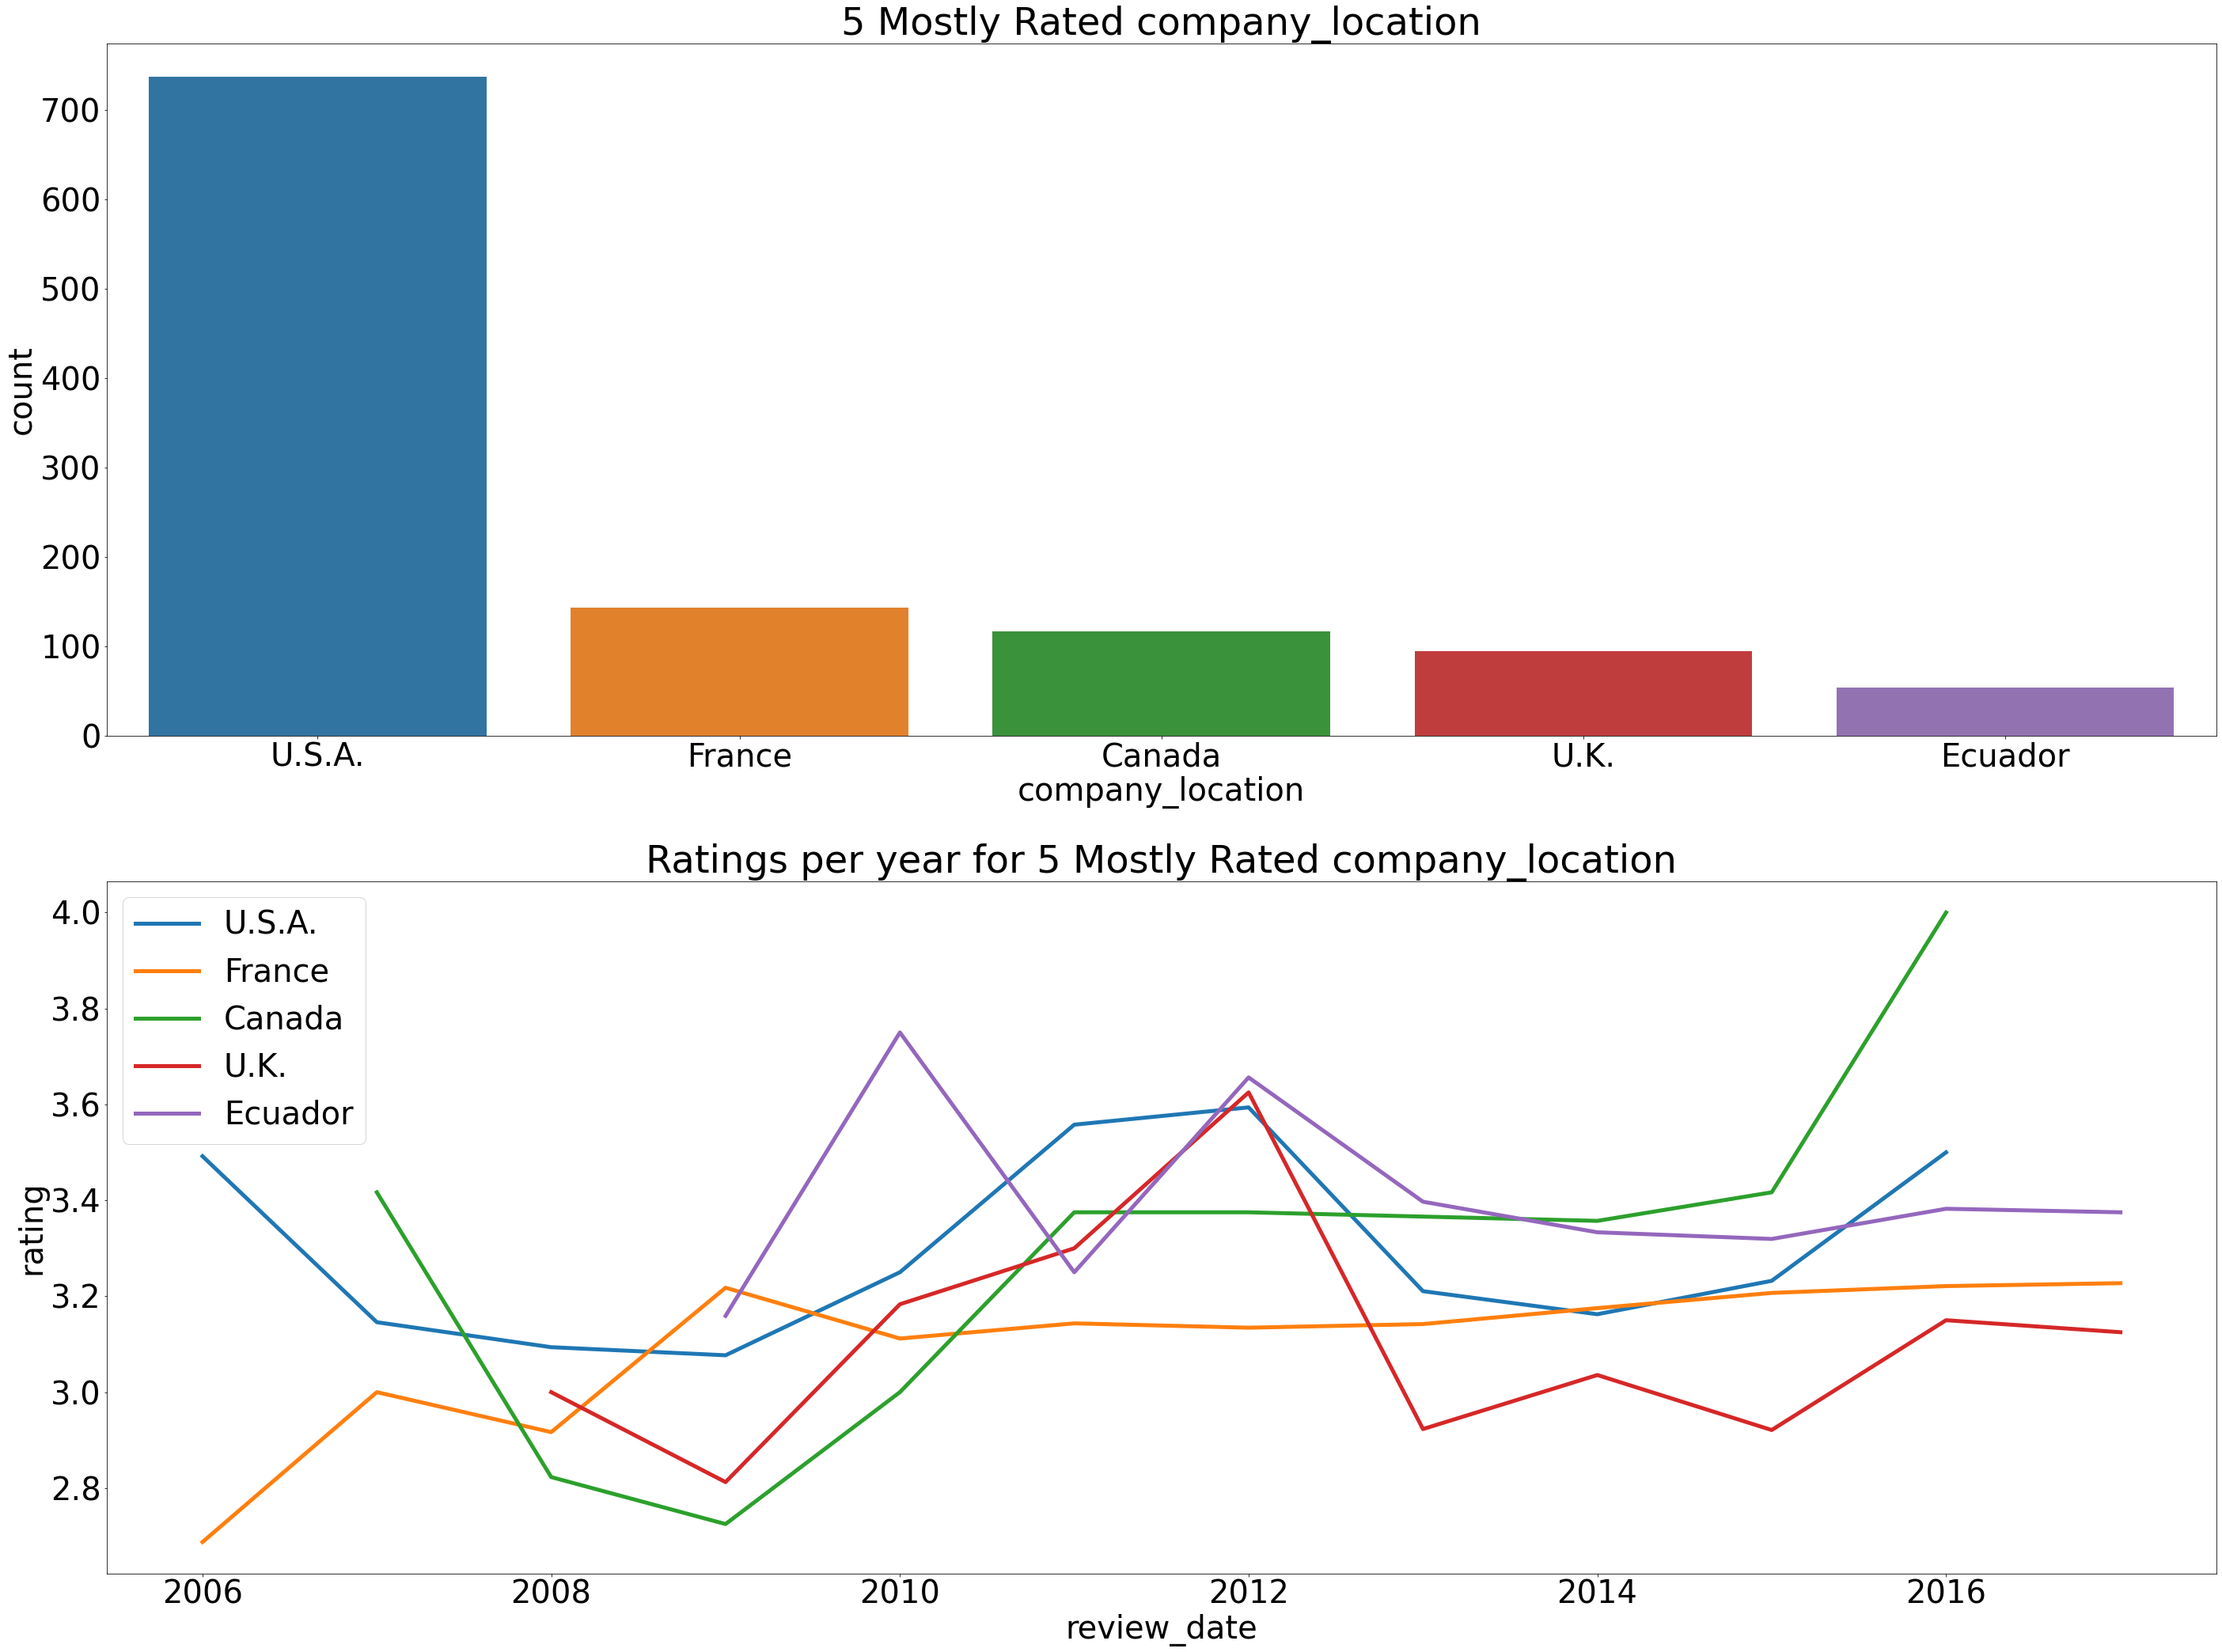

In [407]:
plot_trend('company_location')